### Model

|Type  | Symbol              | Code     | Description     |
|:-----|:-------------------:|:---------|:----------------|
|      | $O_{j}(t,\lambda)$  | O        | observed signal from the $j$-th laser at time $t$ at spectral wavelength $\lambda$  | 
|Const | $s_{i}(\lambda)$    | S        | emission spectrum of sensor associated with $i$-th neuromodulator                   | 
|Const | $e_{j}(\lambda)$    | E        | time-invariant spectral signature of $j$-th excitation laser                        | 
|Const | $\mu_\textrm{oxy}(\lambda)$   | Mu_ox  | Spectrum of oxygenated hemolobin                                            |
|Const | $\mu_\textrm{deoxy}(\lambda)$ | Mu_dox | Spectrum of deoxygenated hemolobin                                          |
|Param | $w_{ij}$              | W        | emission efficiency of $i$-th neuromodulator excited by $j$-th laser              | 
|Param | $a_{i}(t)$            | A        | sensor signal from time varying amount for the $i$-th neuromodulator              | 
|Param | $n_{j}(t)$            | N        | noise from $j$-th laser                                                           | 
|Param | $b_{j}(\lambda)$      | B        | fiber fluorescence triggered by $j$-th laser                                      | 
|Param | $m(t)$                | M        | motion correction (potentially depends on $i$)                                    | 
|Param | $h_\textrm{oxy}(t)$   | H_ox     | Hemodynamics (oxygenated component)                                               |
|Param | $h_\textrm{deoxy}(t)$ | H_dox    | Hemodynamics (deoxygenated component)                                             |

\begin{align*}
O_{j}(t,\lambda)  &= \{ \left( \sum_{i \in \{\textrm{sensors}\},\textrm{autofluorescence}}{\left(a_{i}(t)s_{i}({\lambda})w_{ij}\right)} + e_{j}(\lambda) \right) &\\
& \times \exp \left[ -\left[ h_{\textrm{oxy}}(t)\mu_{\textrm{oxy}}(\lambda)
+ h_{\textrm{deoxy}}(t)\mu_{\textrm{deoxy}}(\lambda) \right]\right] \times m(t) &\\
&+ b_{j}(\lambda) \} \times n_{j}(t)
\end{align*}


- $a_{i}(t)$ for  $i \in \textrm{autofluorescence}$ is slow
- $a_{i}(t)$ for  $i \in \textrm{sensors}$ can be fast (prior: 50 ms to 1 s) or slow (prior: 10 s to 50 s)
- $a_{i}(t) := c_{i}\{f(t)s_\textrm{bright}(\lambda) + (1-f(t))s_\textrm{dark}(\lambda)\}$ : a single sensor population exists in two states (e.g. bright and dark) that have their own emission spectra (also see Isosbestic point).
- $n_{j}(t)$ : white noise spectrum, mostly consists of high frequency components.
- $h_{\textrm{oxy}}(t), h_{\textrm{deoxy}}(t)$ : Slow dynamics, with the fastest dynamics occurring at 0.5 Hz
- For each $j$, a spectral band (around excitation wavelength $\lambda^{\dagger}_{j}$ ) has no information because the pixels are saturated. The diffraction pattern around these pixels is dominated by signal from the laser itself. This might provide an approximation for terms like $h_{\textrm{oxy}}(t)$ ... etc. These could be used as inputs instead of parameters to fit in the above equation.


$$
\def\lexc{\lambda^{\dagger}_{j}}
O_{j}(t,\lexc) = [e_{j}(\lexc) \times\{
h_{\textrm{oxy}}(t)\mu_{\textrm{oxy}}(\lexc)
+h_{\textrm{deoxy}}(t)\mu_{\textrm{deoxy}}(\lexc)\} \times m(t) + b_{j}(\lexc)] \times{n_{j}(t)}$$


### Model for hemodynamics

 - We generate $f(t) \in (0,1)$, and $h(t) \in $ (known ranges of blood hemoglobin concentration). 
 - $h(t)$ is linked to cellular activity in that brain region

$$
h_\textrm{oxy}(t) = f(t)h_{\textrm{total}}(t) \\
h_\textrm{deoxy}(t) = (1 - f(t))h_{\textrm{total}}(t) \\
$$

Here we define $\mu_\textrm{oxy}$ and $\mu_\textrm{deoxy}$ as:
$$
\mu_\textrm{oxy} = \frac{\varepsilon_{\textrm{oxy}} (\lambda) \times c \times {l(\lambda)}}{M_{\textrm{Hg}}}\\
\mu_\textrm{deoxy} = \frac{\varepsilon_{\textrm{deoxy}} (\lambda) \times c \times {l(\lambda)}}{M_{\textrm{Hg}}}\\
$$


TODO:

 - Add Autofluorescence term (maybe fit this)
 - Combine $\varepsilon(\lambda)$ and $l(\lambda)$ terms in absorbance
 - Add constant B (fiber fluorescence) term - Smrithi has this.
 - Motion term (mostly makes the signal dimmer)

```toml
[amplitude] # relative amplitude estimates from Smrithi/Kaspar
A_fast = 1
A_slow = 0.2        # indicator dependent
B = 5               # fiber fluorescence
M = 1               # motion
N = 0.5             # laser noise
H_total_range = 0.1 # 0.05 around 1
f_range = 0.2       # 0.1 around 0.7
```

 - convolve signal with 14 nm wide window along $\lambda$ dim; corresponds to slit image. 
 - add observation noise after the convolution step

In [1]:
# Testing simulation class
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from timebudget import timebudget
sns.set_theme(font_scale=0.8)
%config InlineBackend.figure_format='retina'

from sourcesep.sim import SimData
from sourcesep.utils.config import load_config

paths = load_config(dataset_key='all')
sim = SimData(T=1000, cfg_path=paths['root'] / "sim_config.toml")

Paths are for dataset tagged: all
Paths are for dataset tagged: all


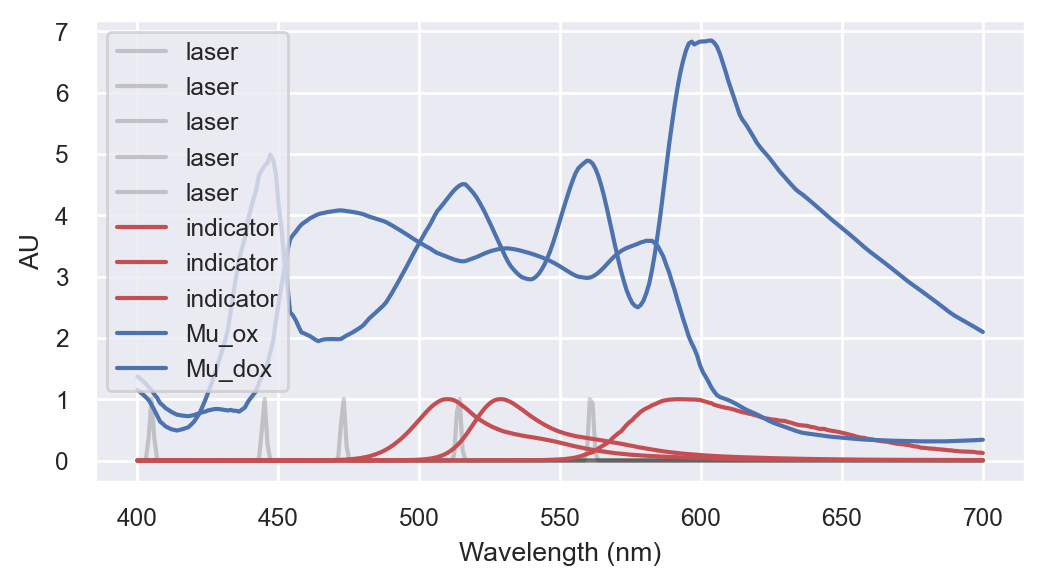

In [2]:
S = sim.get_S()
W = sim.get_W()
E = sim.get_E()
Mu_ox, Mu_dox = sim.get_Mu()

f, ax = plt.subplots(figsize=(6,3))
ax.plot(sim.L_arr, sim.E.T,'k',alpha=0.2,  label='laser')
ax.plot(sim.L_arr, sim.S.T,'r', label='indicator')
ax.plot(sim.L_arr, Mu_ox, 'b',label='Mu_ox')
ax.plot(sim.L_arr, Mu_dox, 'b',label='Mu_dox')
ax.set(xlabel='Wavelength (nm)', ylabel='AU')
plt.legend()
plt.show()


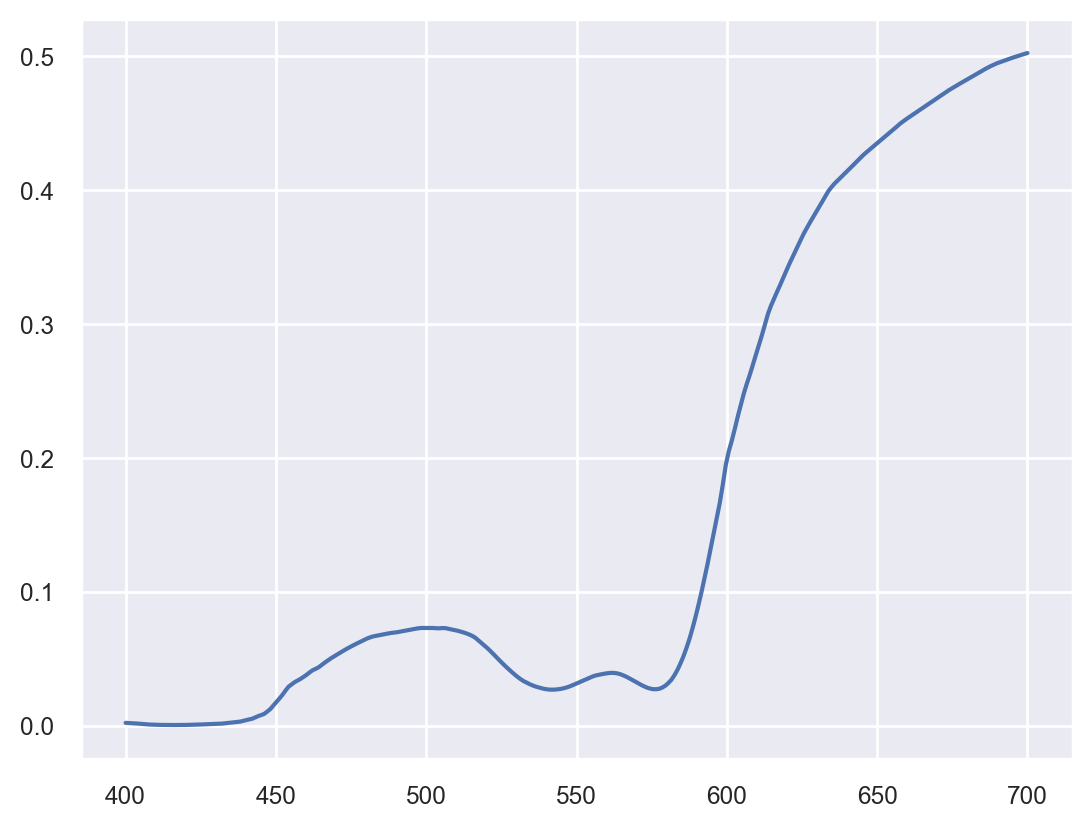

In [3]:
#plt.plot(sim.L_arr, np.log(sim.eps_dox/64500))
plt.plot(sim.L_arr,sim.pathlength)

In [4]:
Mu_ox.shape

(300,)

In [5]:
sim.W_df

,405,445,473,514,561
EGFP,0.1732,0.3915,0.8143,0.1469,0.0043
Venus,0.0572,0.0505,0.2174,1.0000,0.0000
mApple,0.0069,0.0294,0.0920,0.3863,0.8972


activity generation took 763.11ms


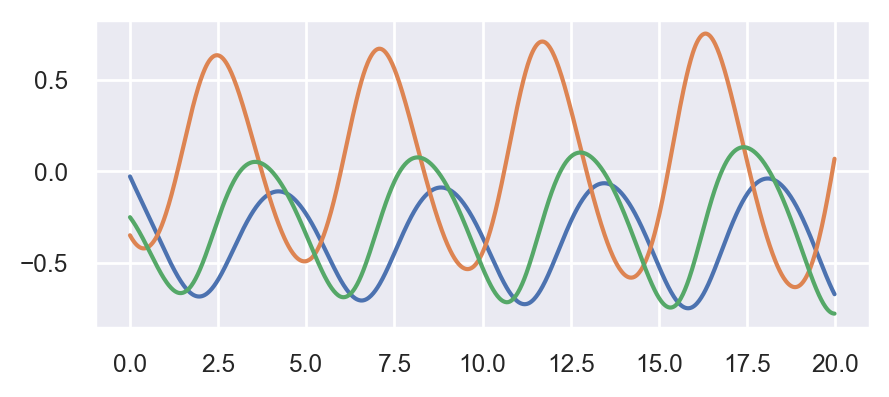

In [6]:
# example activity trace
with timebudget('activity generation'):
    A = sim.gen_A_slow()

plt.subplots(figsize=(5,2))
plt.plot(sim.T_arr, A)
plt.show()

In [7]:
# sample generation time cost
for i in range(10):
    with timebudget('20s sample (1k points)'):
        dat = sim.compose()

20s sample (1k points) took 126.43ms
20s sample (1k points) took 105.31ms
20s sample (1k points) took 108.11ms
20s sample (1k points) took 102.14ms
20s sample (1k points) took 114.80ms
20s sample (1k points) took 94.84ms
20s sample (1k points) took 106.11ms
20s sample (1k points) took 102.30ms
20s sample (1k points) took 96.06ms
20s sample (1k points) took 110.72ms


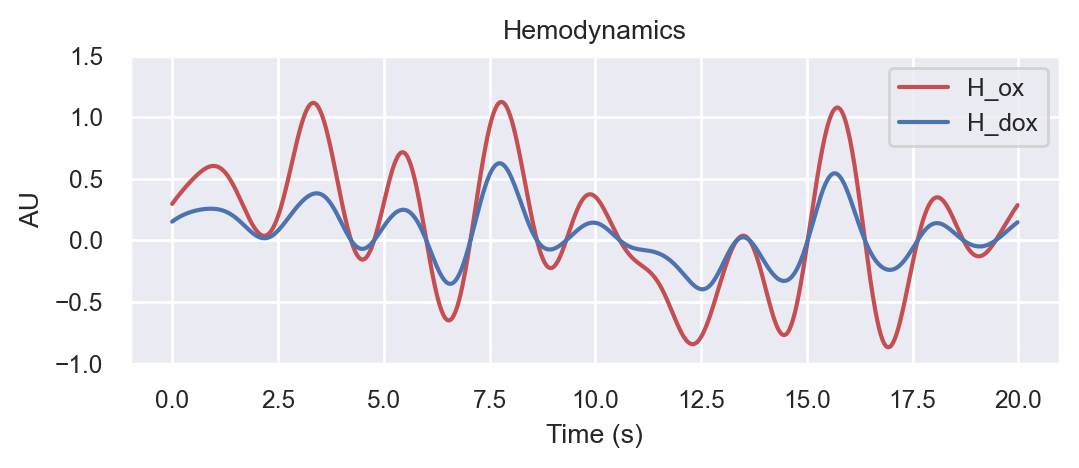

In [8]:
f, ax = plt.subplots(figsize=(6,2))
ax.plot(sim.T_arr, dat['H_ox'], 'r',label='H_ox')
ax.plot(sim.T_arr, dat['H_dox'], 'b',label='H_dox')
ax.set(xlabel='Time (s)', ylabel='AU', ylim=[-1, 1.5], title='Hemodynamics')
plt.legend()
plt.show()

[(0.0, 1.0)]

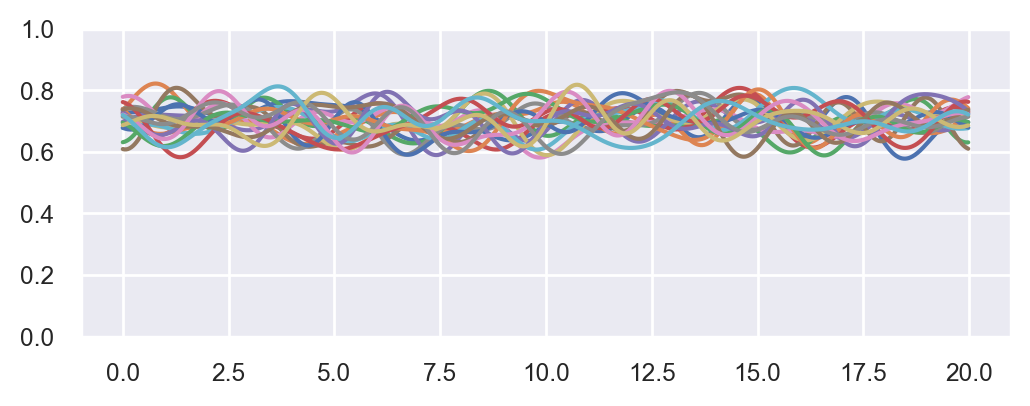

In [12]:
_, ax = plt.subplots(figsize=(6,2))

for i in range(20):
    H_ox, H_dox, H_total, f = sim.gen_H()
    ax.plot(sim.T_arr, f)
ax.set(ylim=(0,1))


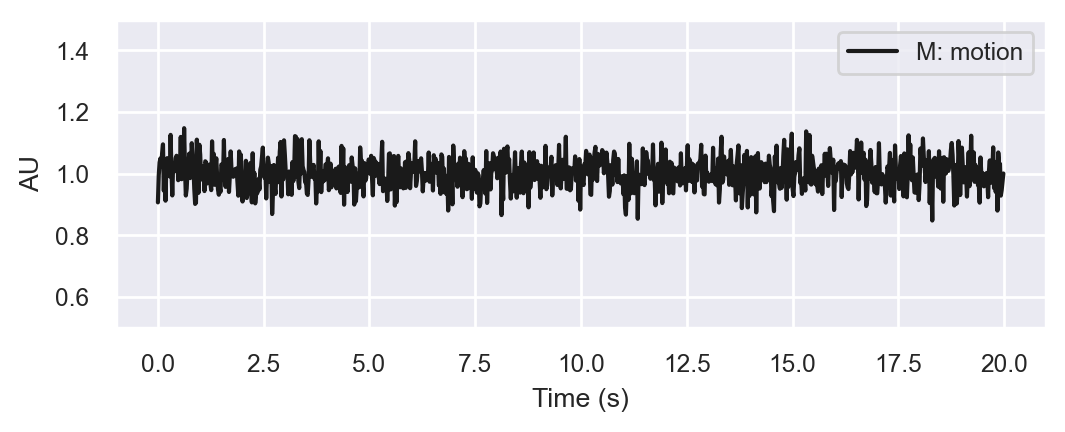

In [7]:
f, ax = plt.subplots(figsize=(6,2))
ax.plot(sim.T_arr, dat['M'], 'k',label='M: motion')
ax.set(xlabel='Time (s)', ylabel='AU', ylim=[0.5, 1.5])
plt.legend()
plt.show()

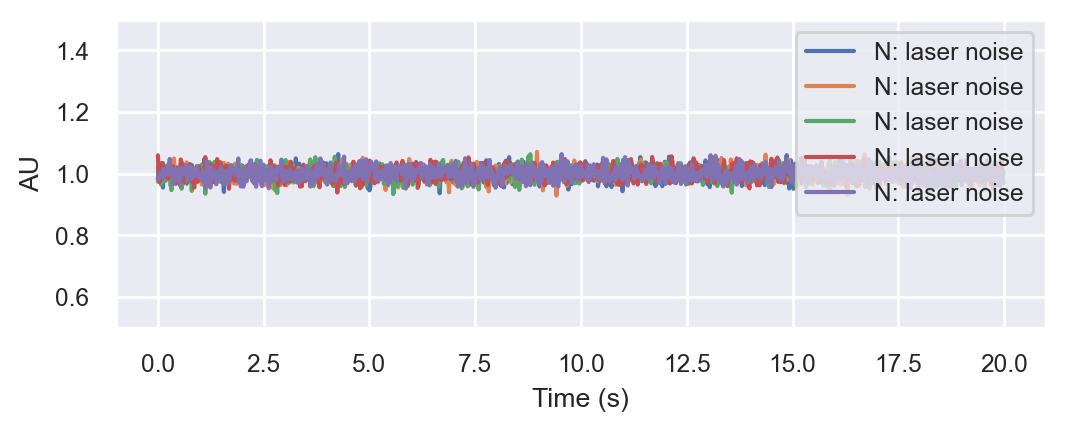

In [8]:
f, ax = plt.subplots(figsize=(6,2))
ax.plot(sim.T_arr, dat['N'],label='N: laser noise')
ax.set(xlabel='Time (s)', ylabel='AU', ylim=[0.5, 1.5])
plt.legend()
plt.show()

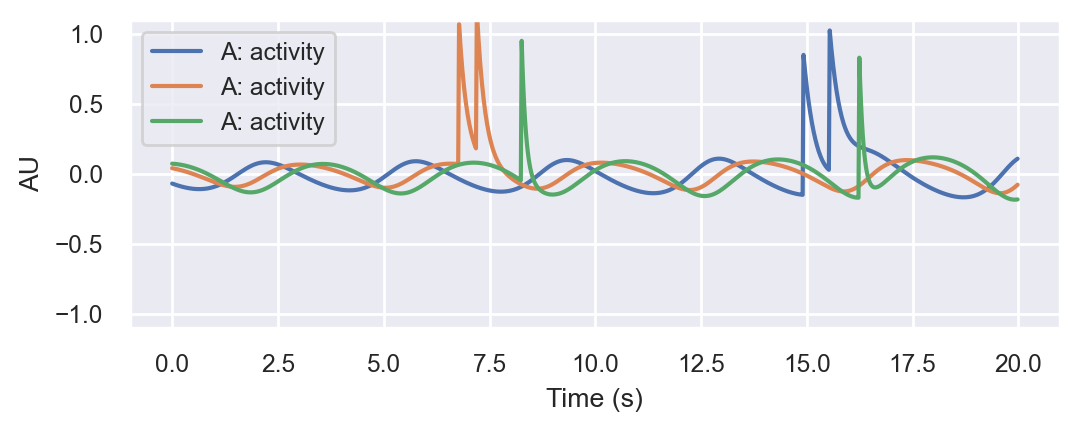

In [9]:
f, ax = plt.subplots(figsize=(6,2))
ax.plot(sim.T_arr, dat['A'],label='A: activity')
ax.set(xlabel='Time (s)', ylabel='AU', ylim=[-1.1, 1.1])
plt.legend()
plt.show()

In [10]:
sim.cfg['indicator'].keys()

dict_keys(['EGFP', 'Venus', 'mApple'])

In [11]:
dat['O'].shape

(1000, 5, 300)

In [12]:
sim.cfg['laser']

{'l0': {'em_wavelength_nm': 405},
 'l1': {'em_wavelength_nm': 445},
 'l2': {'em_wavelength_nm': 473},
 'l3': {'em_wavelength_nm': 514},
 'l4': {'em_wavelength_nm': 561}}

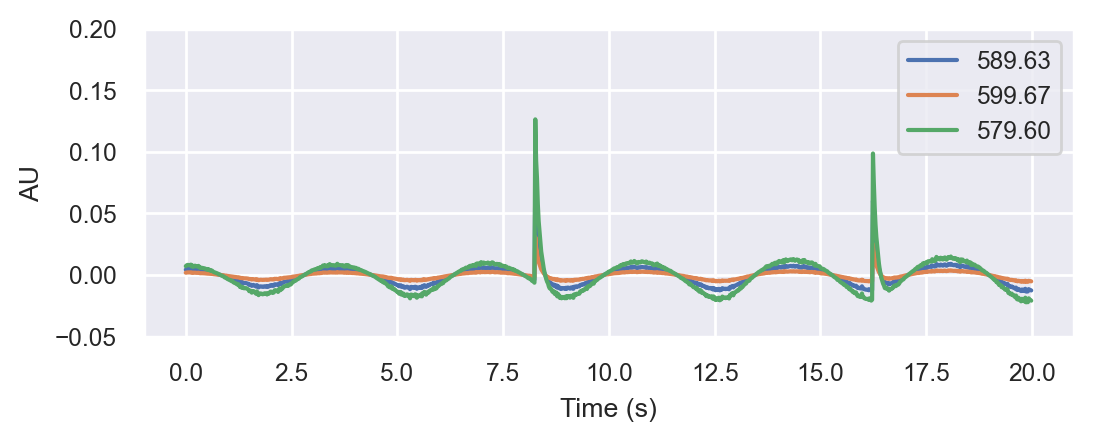

In [13]:
# dims are tjl for O
wavelength = 590
l = np.argmin(np.abs(sim.L_arr - wavelength))
j = 4

f, ax = plt.subplots(figsize=(6,2))
ax.plot(sim.T_arr, dat['O'][:,j, l], label=f'{sim.L_arr[l]:0.2f}')
ax.plot(sim.T_arr, dat['O'][:,j, l+10], label=f'{sim.L_arr[l+10]:0.2f}')
ax.plot(sim.T_arr, dat['O'][:,j, l-10], label=f'{sim.L_arr[l-10]:0.2f}')
ax.set(xlabel='Time (s)', ylabel='AU', ylim=[-.05, 0.2])
plt.legend()
plt.show()